In [2]:
### Paquetes y Base de datos

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from scipy.stats import genpareto, invgamma, lognorm, gaussian_kde


df = pd.read_csv(r"..\data\clean\datos_limpios.csv")

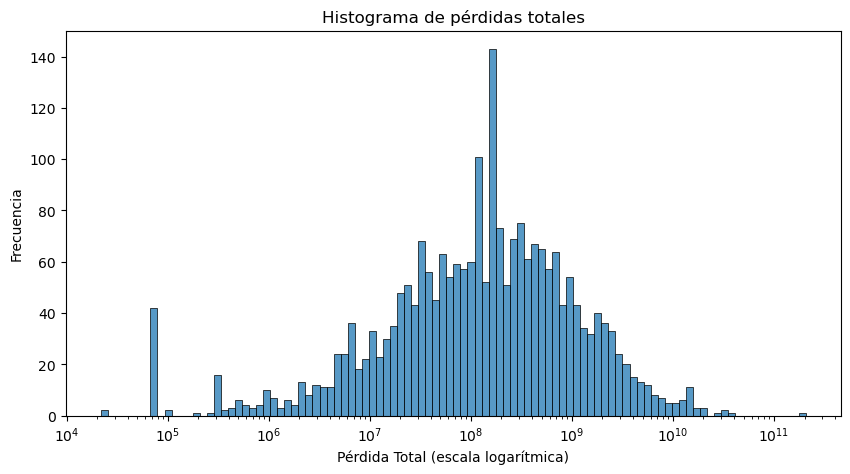

In [8]:
plt.figure(figsize=(10,5))
sns.histplot(df['total'], bins=100, log_scale=True)
plt.title("Histograma de pérdidas totales")
plt.xlabel('Pérdida Total (escala logarítmica)')
plt.ylabel('Frecuencia')
plt.show()

c:\Users\andre\anaconda3\envs\Proyectos\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


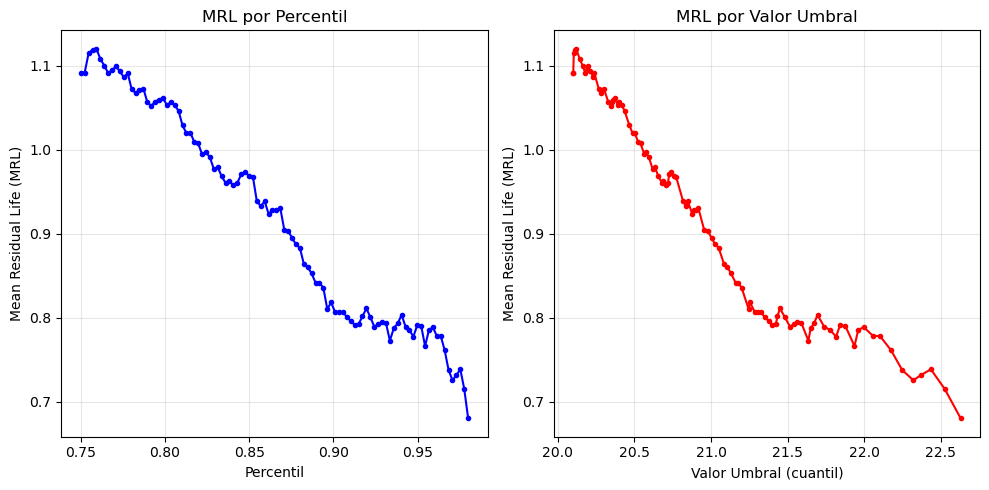

In [ ]:
### Estimación del u donde cortar el histograma

y = np.log(df['total'])
malla = np.linspace(0.75, 0.98, 100)
resultados = []
for p in malla:
    umbral = np.quantile(y, p)
    datos = y[y >= umbral]
    residuos = datos-umbral
    mrl = np.mean(residuos)
    n_obs = len(residuos)
    resultados.append({
        'percentil': p,
        'umbral': umbral,
        'mrl': mrl,
        'n_obs': n_obs,
    })
resultados = pd.DataFrame(resultados)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(resultados['percentil'], resultados['mrl'], 'b-o', markersize=3)
plt.xlabel('Percentil')
plt.ylabel('Mean Residual Life (MRL)')
plt.title('MRL por Percentil')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(resultados['umbral'], resultados['mrl'], 'r-o', markersize=3)
plt.xlabel('Valor Umbral (cuantil)')
plt.ylabel('Mean Residual Life (MRL)')
plt.title('MRL por Valor Umbral')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Según este gráfico y la teoría se debe buscar donde la curva sea más plana, en este caso es alrededor del percentil 90 a 95. Pero se harán unos tests de estabilidad y alineación con la Distribución Generalizada de Pareto para elegir el umbral óptimo y así poder modelar de una merjo manera la cola de la distribución.

In [ ]:
def exceedances(x, u):
    x = np.asarray(x)
    exc = x[x > u] - u
    return exc

def fit_gpd_mle(exceed):
    # scipy's genpareto: shape=c=xi, loc, scale=beta
    c, loc, scale = genpareto.fit(exceed, floc=0.0)
    xi = c
    beta = scale
    return xi, beta

def bootstrap_xi(exceed, B=300, seed=123):
    rng = np.random.default_rng(seed)
    n = len(exceed)
    if n <= 1:
        return np.array([])
    xis = []
    for _ in range(B):
        sample = exceed[rng.integers(0, n, size=n)]
        try:
            xi, _ = fit_gpd_mle(sample)
            xis.append(xi)
        except Exception:
            # skip failed fits
            pass
    return np.array(xis)

def xi_stability(x, thresholds, do_bootstrap=False, B=300):
    xs = []
    xis = []
    xi_lo = []
    xi_hi = []
    counts = []
    for u in thresholds:
        exc = exceedances(x, u)
        counts.append(len(exc))
        if len(exc) < 20:
            xs.append(u)
            xis.append(np.nan)
            xi_lo.append(np.nan)
            xi_hi.append(np.nan)
            continue
        xi, _ = fit_gpd_mle(exc)
        xs.append(u)
        xis.append(xi)
        if do_bootstrap:
            boots = bootstrap_xi(exc, B=B)
            if len(boots) > 0:
                lo = np.percentile(boots, 2.5)
                hi = np.percentile(boots, 97.5)
            else:
                lo, hi = np.nan, np.nan
            xi_lo.append(lo)
            xi_hi.append(hi)
        else:
            xi_lo.append(np.nan)
            xi_hi.append(np.nan)
    return np.array(xs), np.array(xis), np.array(xi_lo), np.array(xi_hi), np.array(counts)

def plot_xi_stability(x, thresholds, do_bootstrap=False, B=300):
    xs, xis, lo, hi, counts = xi_stability(x, thresholds, do_bootstrap, B)
    fig, ax1 = plt.subplots()
    ax1.plot(xs, xis, marker='o')
    ax1.set_xlabel("Umbral u (valor)")
    ax1.set_ylabel("Estimación xi (GPD)")
    ax1.grid(True, alpha=0.3)
    if do_bootstrap:
        ax1.fill_between(xs, lo, hi, alpha=0.2)
    plt.title("Estabilidad de xi vs umbral")
    plt.show()

    # Secondary plot: xi vs percentil equivalente
    qs = [np.mean(x <= u) for u in xs]
    fig2, ax2 = plt.subplots()
    ax2.plot(qs, xis, marker='o')
    ax2.set_xlabel("Percentil del umbral")
    ax2.set_ylabel("Estimación xi (GPD)")
    ax2.grid(True, alpha=0.3)
    if do_bootstrap:
        ax2.fill_between(qs, lo, hi, alpha=0.2)
    plt.title("Estabilidad de xi vs percentil del umbral")
    plt.show()

    # Table of counts per threshold
    df = pd.DataFrame({"umbral": xs, "percentil": qs, "excedencias": counts, "xi": xis})
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user("Resumen_xi_por_umbral", df)
    except Exception:
        pass
    return df

def qqplot_exceedances(x, u):
    exc = exceedances(x, u)
    if len(exc) < 20:
        raise ValueError("Muy pocas excedencias por encima del umbral elegido.")
    xi, beta = fit_gpd_mle(exc)

    # Empirical quantiles
    exc_sorted = np.sort(exc)
    n = len(exc_sorted)
    probs = (np.arange(1, n + 1) - 0.5) / n
    # Theoretical GPD quantiles with loc=0
    q_theo = genpareto.ppf(probs, c=xi, loc=0, scale=beta)

    fig, ax = plt.subplots()
    ax.scatter(q_theo, exc_sorted, s=12)
    # 45-degree reference line
    lo = min(q_theo.min(), exc_sorted.min())
    hi = max(q_theo.max(), exc_sorted.max())
    ax.plot([lo, hi], [lo, hi])
    ax.set_xlabel("Cuantiles teóricos GPD")
    ax.set_ylabel("Cuantiles empíricos de excedencias")
    ax.set_title(f"QQ-plot GPD (u={u:.3g}, excedencias={n}, xi={xi:.3f})")
    ax.grid(True, alpha=0.3)
    plt.show()

    return {"u": u, "xi": xi, "beta": beta, "n_excedencias": n}

def load_series_from_csv(csv_path, col):
    df = pd.read_csv(csv_path)
    if col not in df.columns:
        raise ValueError(f"La columna '{col}' no está en el CSV. Columnas encontradas: {list(df.columns)}")
    x = df[col].dropna().values
    x = np.asarray(x, dtype=float)
    x = x[x > 0]
    return x

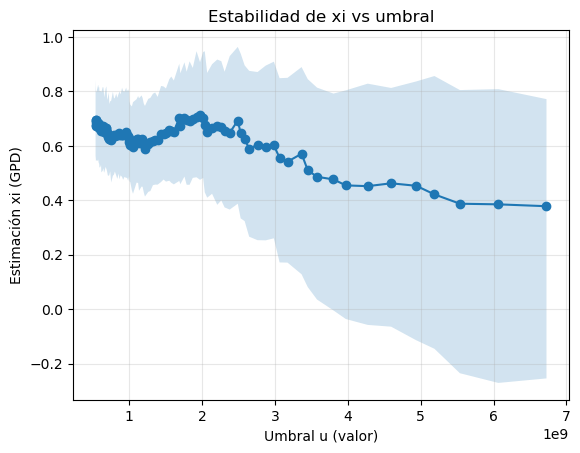

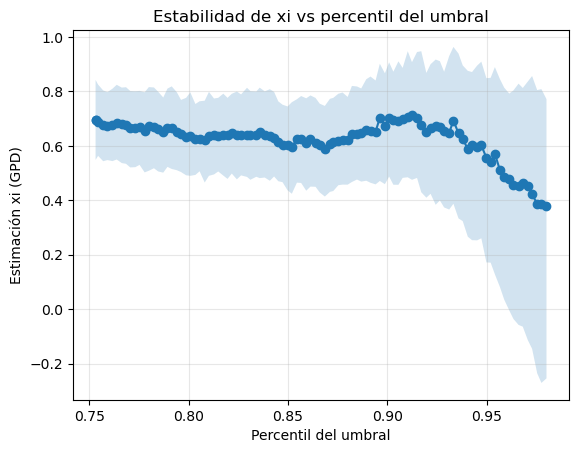

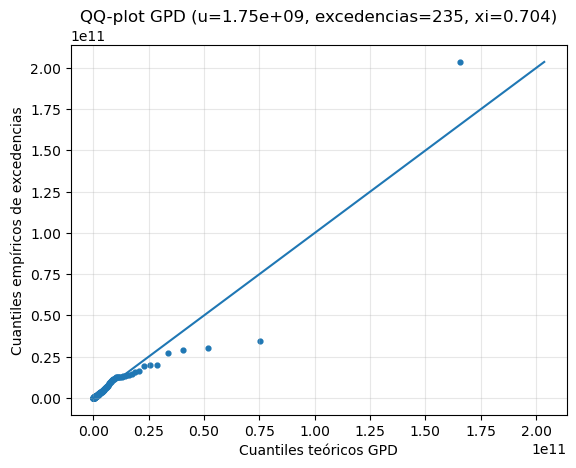

{'u': np.float64(1745016156.0), 'xi': np.float64(0.7042925313916653), 'beta': np.float64(1553185274.1373508), 'n_excedencias': 235}


In [ ]:
x = load_series_from_csv(r'../data/clean/datos_limpios.csv', 'total')
thresholds = [np.quantile(x, q) for q in malla]
_ = plot_xi_stability(x, thresholds, do_bootstrap=True, B=500)
u = np.quantile(x, 0.9)
res = qqplot_exceedances(x, u)
print(res)

Se tomará el percentil 93 para el umbral

In [8]:
cuerpo = df[df['total'] <= u]
cola = df[df['total'] > u]
len(cuerpo), len(cola)

(2186, 165)

Para el cuerpo se intentará primero ajustar por medio de una lognormal pero para la cola se usará la distribución generalizada de Pareto con el xi y beta calculados anteriormente.

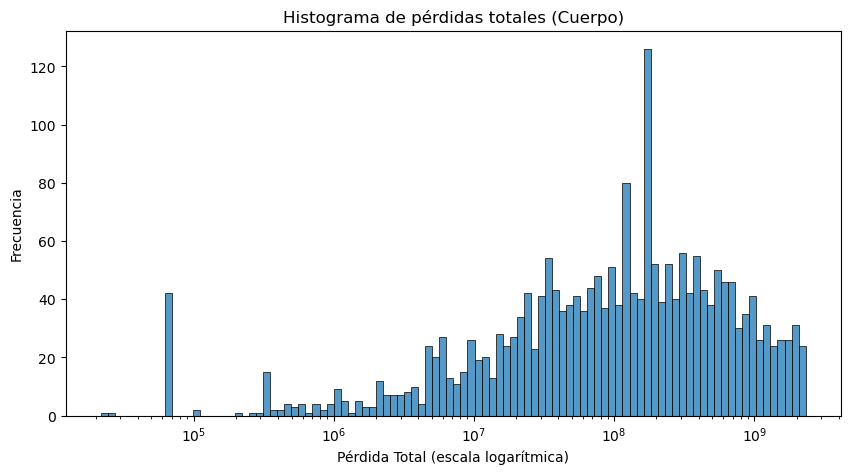

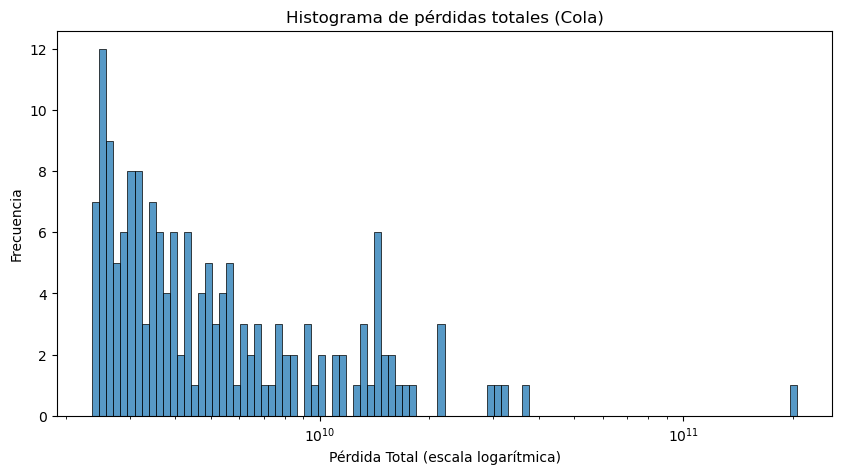

In [9]:
## Cuerpo

plt.figure(figsize=(10,5))
sns.histplot(cuerpo['total'], bins=100, log_scale=True)
plt.title("Histograma de pérdidas totales (Cuerpo)")
plt.xlabel('Pérdida Total (escala logarítmica)')
plt.ylabel('Frecuencia')
plt.show()

## Cola

plt.figure(figsize=(10,5))
sns.histplot(cola['total'], bins=100, log_scale=True)
plt.title("Histograma de pérdidas totales (Cola)")
plt.xlabel('Pérdida Total (escala logarítmica)')
plt.ylabel('Frecuencia')
plt.show()

## Cuerpo

Se intentarán ajustar los parámetros de una lognormal, para esto se asumirán las siguientes previas dado la teoría

$$
\mu \mid \sigma^2 \sim \mathcal{N}(\mu_0,\tau_0^2)
$$
$$
\sigma^2 \sim \Gamma^{-1}(v_0/2, v_0\sigma_0^2/2)
$$

In [10]:
y = np.log(cuerpo[cuerpo['total']>0]['total'].values)
n = len(y)
ybar = y.mean()
yvar = y.var(ddof=1)
ysum = y.sum()

print('ybar: ', ybar)
print('yvar: ', yvar)
print('ysum: ', ysum)

mu0 = 20
t20 = 0.5**2
s20 = 4000
nu0 = 1

S = 100000
phi = np.empty(2, dtype=float)
ncat = np.floor(S/10)

rng_init = np.random.default_rng(2025)
# phi[0] ~ Normal(mu0, t20)
phi[0] = rng_init.normal(loc = mu0, scale = np.sqrt(t20))
shape = nu0/2
rate = (nu0*s20)/2
# phi[1] ~ Gamma(shape=nu0/2, rate=nu0*s20/2)
phi[1] = rng_init.gamma(shape = shape, scale = 1/rate)

PHI = np.empty((S, 2), dtype=float)
PHI[0, :] = phi

rng = np.random.default_rng(153702)

for s in range(1, S):
    t2n = 1.0 / (1.0 / t20 + n * phi[1])
    mun = (mu0 / t20 + ysum * phi[1]) * t2n
    phi[0] = rng.normal(loc=mun, scale=np.sqrt(t2n))

    nun = nu0 + n
    s2n = (nu0 * s20 + (n - 1) * yvar + n * (ybar - phi[0])**2) / nun
    shape = nun / 2.0
    rate  = nun * s2n / 2.0
    phi[1] = rng.gamma(shape=shape, scale=1.0 / rate)

    PHI[s, :] = phi

    if ( (s + 1) % ncat == 0 ):
        pct = round(100.0 * (s + 1) / S, 1)
        print(f"{pct}% completado ...")



ybar:  18.261995646637345
yvar:  4.488924401725024
ysum:  39902.4604879026
10.0% completado ...
20.0% completado ...
30.0% completado ...
40.0% completado ...
50.0% completado ...
60.0% completado ...
70.0% completado ...
80.0% completado ...
90.0% completado ...
100.0% completado ...


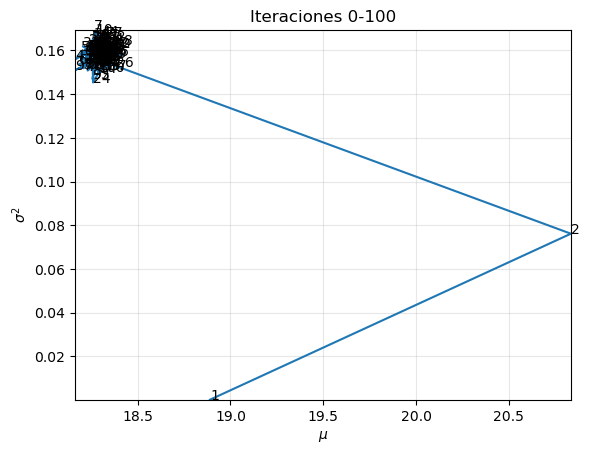

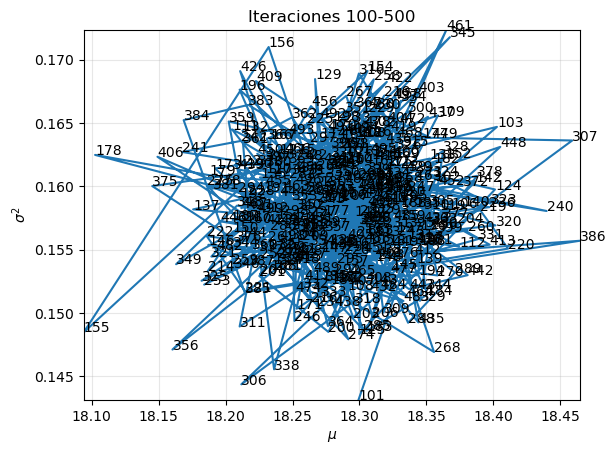

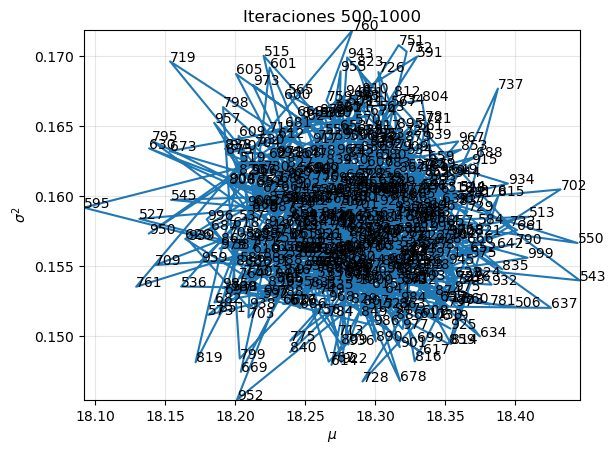

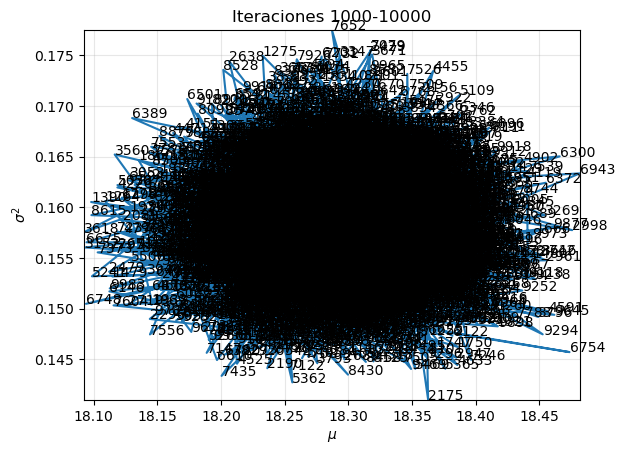

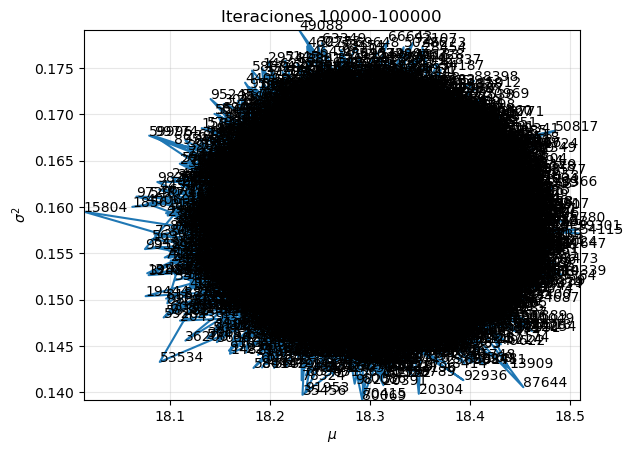

In [11]:
def phase_plot(PHI, inf, sup):
    PHI = np.asarray(PHI)
    xlim = (PHI[inf:sup, 0].min(), PHI[inf:sup, 0].max())
    ylim = (PHI[inf:sup, 1].min(), PHI[inf:sup, 1].max())

    fig, ax = plt.subplots()
    ax.plot(PHI[inf:sup, 0], PHI[inf:sup, 1], linestyle='-')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel(r'${\sigma}^2$')
    ax.set_title(f'Iteraciones {inf}-{sup}')
    ax.grid(True, alpha=0.3)

    for i in range(inf, sup):
        ax.text(PHI[i, 0], PHI[i, 1], str(i+1))

    plt.show()

phase_plot(PHI, inf=0, sup = 100)
phase_plot(PHI, inf=100, sup = 500)
phase_plot(PHI, inf=500, sup = 1000)
phase_plot(PHI, inf=1000, sup = 10000)
phase_plot(PHI, inf=10000, sup = 100000)

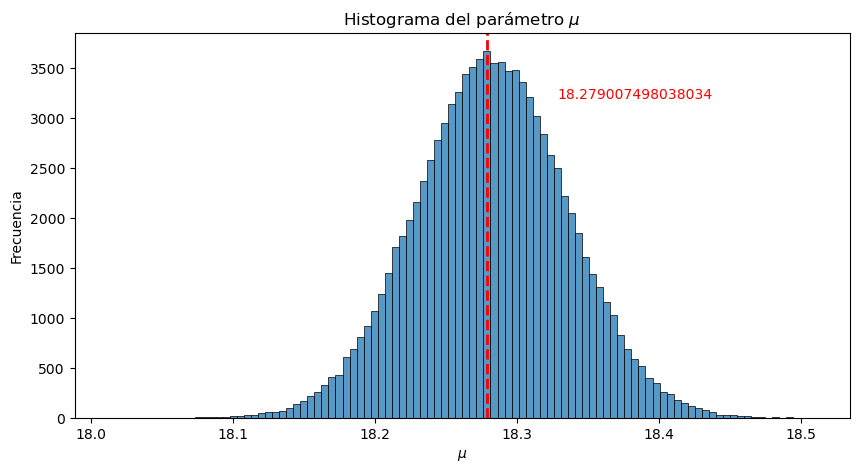

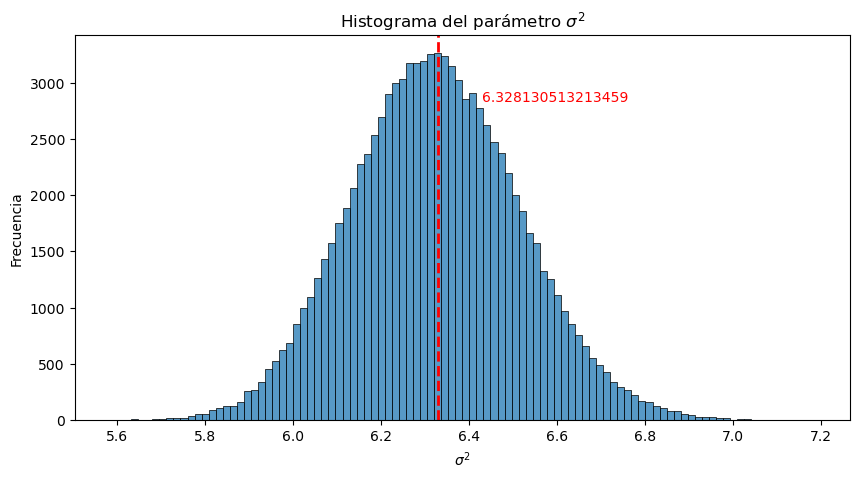

In [38]:
x = PHI[1000:, 0]
bins = 100

counts, edges = np.histogram(x, bins=bins)
imax = counts.argmax()              
x_vline = 0.5 * (edges[imax] + edges[imax+1]) 

plt.figure(figsize=(10,5))
ax = sns.histplot(x, bins=bins)
ax.axvline(x_vline, linestyle="--", linewidth=2, color="red")
ax.text(x_vline+0.05, counts.max()*0.9, f"{x_vline}", rotation=0, va="top", color="red")
plt.title(r"Histograma del parámetro $\mu$")
plt.xlabel(r'$\mu$'); plt.ylabel('Frecuencia')
plt.show()


y_raw = 1.0 / PHI[1000:, 1] 

counts2, edges2 = np.histogram(y_raw, bins=bins)
imax2 = counts2.argmax()
x_vline2 = 0.5 * (edges2[imax2] + edges2[imax2+1])

plt.figure(figsize=(10,5))
ax2 = sns.histplot(y_raw, bins=bins)
ax2.axvline(x_vline2, linestyle="--", linewidth=2, color = "red")
ax2.text(x_vline2+0.1, counts2.max()*0.9, f"{x_vline2}", rotation=0, va="top", color = "red")
plt.title(r"Histograma del parámetro $\sigma^2$")
plt.xlabel(r'$\sigma^2$'); plt.ylabel('Frecuencia')
plt.show()


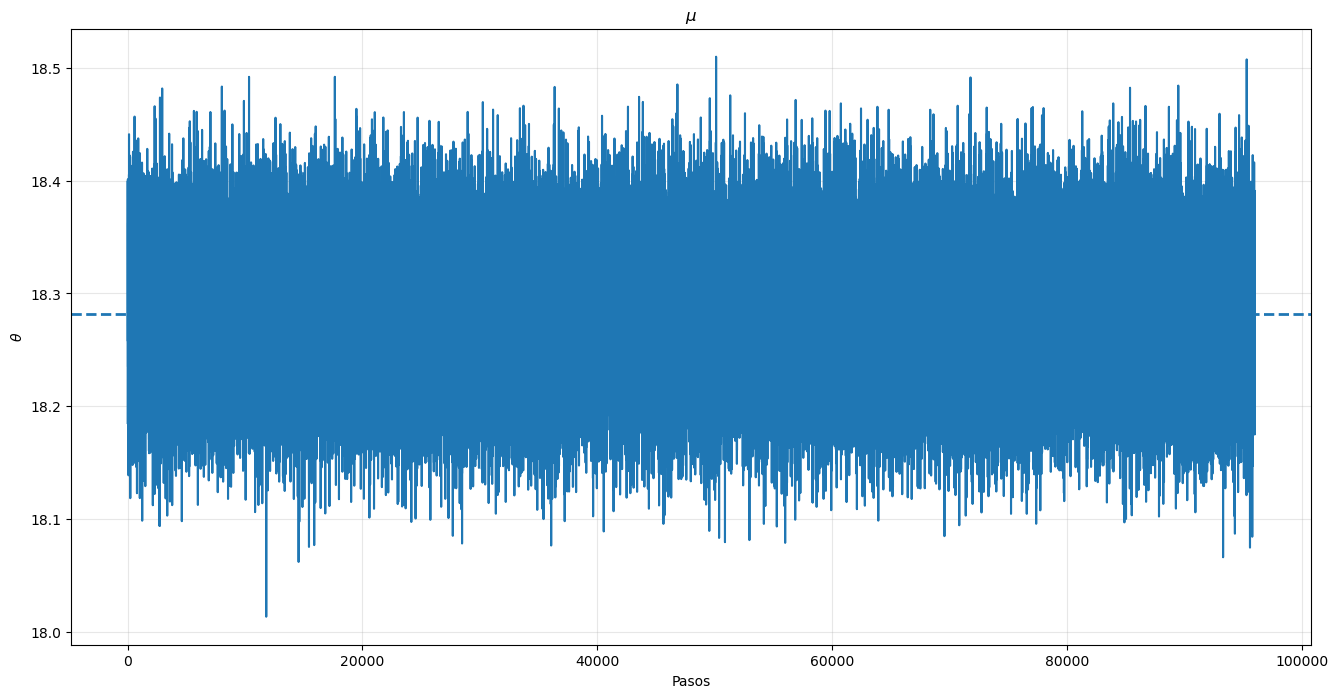

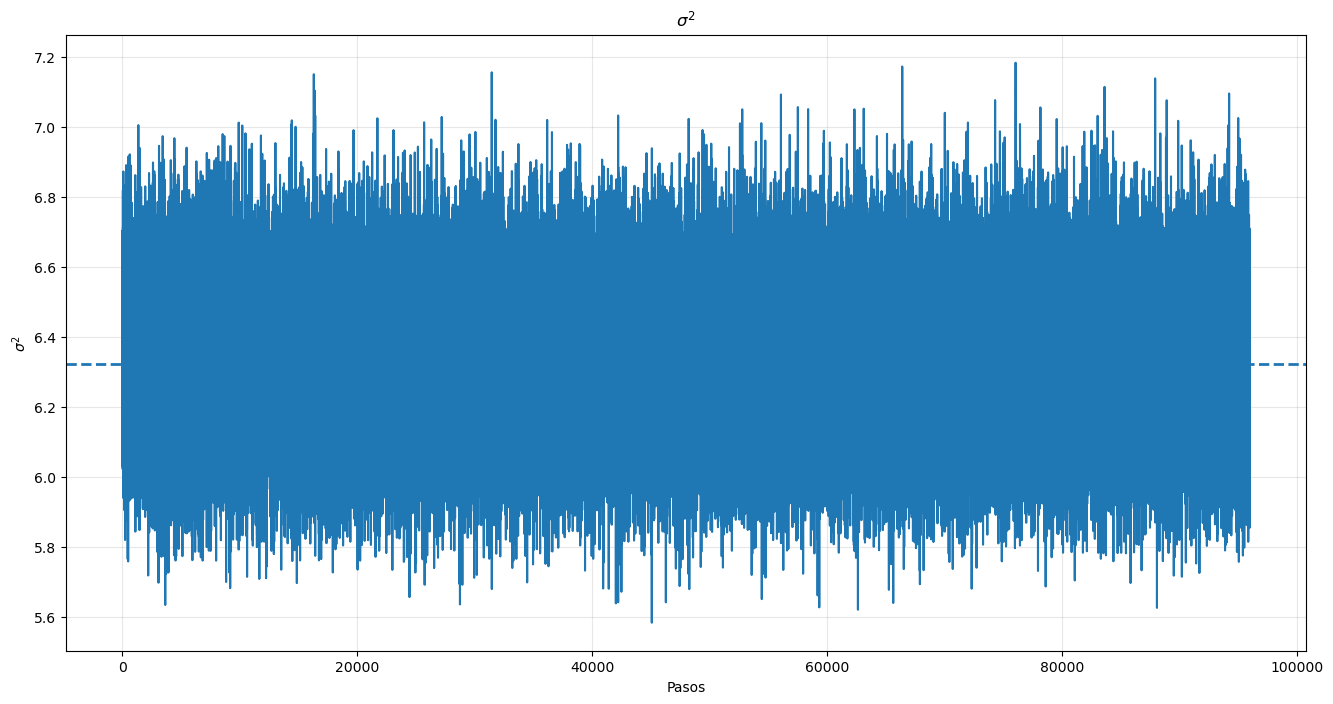

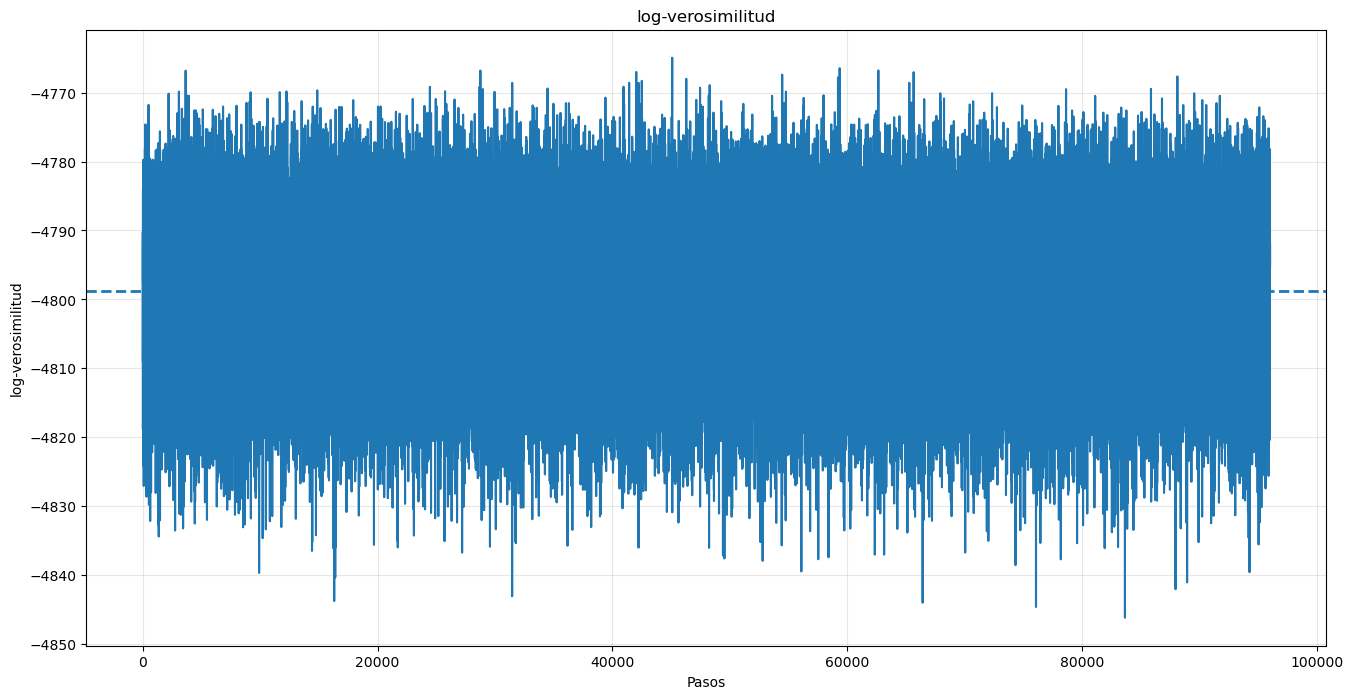

In [56]:
from scipy.stats import norm

PHI = PHI[1000:, :]

S = PHI.shape[0]
LL = np.empty(S, dtype=float)
for i in range(S):
    theta_i = PHI[i, 0]
    tau_i   = PHI[i, 1]
    sd_i    = np.sqrt(1.0 / tau_i)
    LL[i]   = np.sum(norm.logpdf(y, loc=theta_i, scale=sd_i))

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(PHI[:, 0])
ax.set_xlabel("Pasos")
ax.set_ylabel(r"$\theta$")
ax.axhline(PHI[:, 0].mean(), linestyle="--", linewidth=2)
ax.set_title(r"$\mu$")
ax.grid(True, alpha=0.3)
plt.show()

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(1/PHI[:, 1])
ax.set_xlabel("Pasos")
ax.set_ylabel(r"$\sigma^2$")
ax.axhline((1.0 / PHI[:, 1]).mean(), linestyle="--", linewidth=2)
ax.set_title(r"$\sigma^2$")
ax.grid(True, alpha=0.3)
plt.show()

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(LL)
ax.set_xlabel("Pasos")
ax.set_ylabel("log-verosimilitud")
ax.axhline(LL.mean(), linestyle="--", linewidth=2)
ax.set_title("log-verosimilitud")
ax.grid(True, alpha=0.3)
plt.show()


<Figure size 640x480 with 0 Axes>

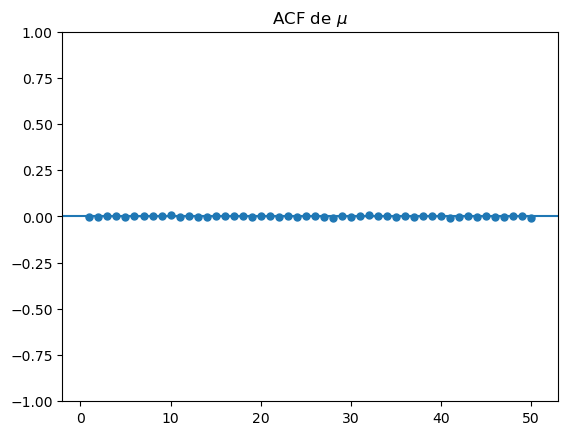

<Figure size 640x480 with 0 Axes>

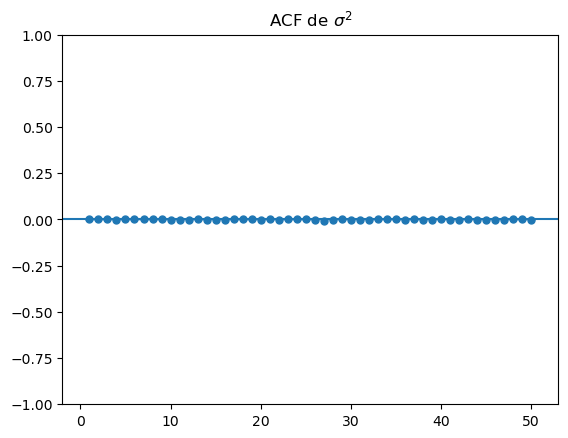

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

# ACF de theta
plt.figure()
plot_acf(PHI[:, 0], lags=50, zero=False)
plt.title(r"ACF de $\mu$")
plt.show()

# ACF de sigma^2
plt.figure()
plot_acf(PHI[:, 1], lags=50, zero=False)
plt.title(r"ACF de $\sigma^2$")
plt.show()
